# EDA example - Marketing analytics

<div>
<img src="images/marketing.PNG" width="400"/>
</div>


1. [Wrangling data](#section1)

   1.1 [Fix columns](#section1.1)   
   1.2 [Missing values](#section1.2)  
   1.3 [Outliers](#section1.3)    
   1.4 [Transformations](section1.4)
  
2. [Understand the data](#section2)
3. [Correlations](#section3)
4. [Categorical data](#section4)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

We'll work with a small marketing analytics dataset, taken from [iFood](https://www.crunchbase.com/organization/ifood)

Based on the example [here](https://www.kaggle.com/jennifercrockett/marketing-analytics-eda-task-final)

In [2]:
url = 'https://raw.githubusercontent.com/nlihin/data-analytics/main/datasets/marketing_data.csv'
mrkt_df = pd.read_csv(url)
mrkt_df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,1826,1970,Graduation,Divorced,"$84,835.00",0,0,6/16/14,0,189,...,6,1,0,0,0,0,0,1,0,SP
1,1,1961,Graduation,Single,"$57,091.00",0,0,6/15/14,0,464,...,7,5,0,0,0,0,1,1,0,CA
2,10476,1958,Graduation,Married,"$67,267.00",0,1,5/13/14,0,134,...,5,2,0,0,0,0,0,0,0,US
3,1386,1967,Graduation,Together,"$32,474.00",1,1,5/11/14,0,10,...,2,7,0,0,0,0,0,0,0,AUS
4,5371,1989,Graduation,Single,"$21,474.00",1,0,4/8/14,0,6,...,2,7,1,0,0,0,0,1,0,SP


Data description in an image, and also [here](https://www.kaggle.com/jackdaoud/marketing-data)

<div>
<img src="images/ifood.png" width="700"/>
</div>



<a id='section1'></a>

---
### 1. Wrangling data



<a id='section1.1'></a>

#### 1.1 Fix columns

You may already notice something is strange with the Income column, is it aligned to the right??

Let's look at the types of data

In [3]:
mrkt_df.dtypes

ID                      int64
Year_Birth              int64
Education              object
Marital_Status         object
 Income                object
Kidhome                 int64
Teenhome                int64
Dt_Customer            object
Recency                 int64
MntWines                int64
MntFruits               int64
MntMeatProducts         int64
MntFishProducts         int64
MntSweetProducts        int64
MntGoldProds            int64
NumDealsPurchases       int64
NumWebPurchases         int64
NumCatalogPurchases     int64
NumStorePurchases       int64
NumWebVisitsMonth       int64
AcceptedCmp3            int64
AcceptedCmp4            int64
AcceptedCmp5            int64
AcceptedCmp1            int64
AcceptedCmp2            int64
Response                int64
Complain                int64
Country                object
dtype: object

So here is the problem: the 'Income' column contains extra whitespace, clean it:

In [4]:
mrkt_df.columns = mrkt_df.columns.str.replace(' ', '')

And: the 'Income' column should be turned to numeric (float is better)

regex: regular expression. We want the `$` sign treated as a string so regex should be set to False

In [5]:
mrkt_df['Income'] = mrkt_df['Income'].str.replace('$', '', regex = False)

In [6]:
mrkt_df['Income'] = mrkt_df['Income'].str.replace(',', '')

In [7]:
mrkt_df['Income'] = mrkt_df['Income'].astype(float)

Check that our changes worked:

In [8]:
mrkt_df.dtypes['Income']

dtype('float64')

<a id='section1.2'></a>

#### 1.2 Missing values

In [9]:
mrkt_df.isnull().sum().sort_values(ascending=False)

Income                 24
ID                      0
NumDealsPurchases       0
Complain                0
Response                0
AcceptedCmp2            0
AcceptedCmp1            0
AcceptedCmp5            0
AcceptedCmp4            0
AcceptedCmp3            0
NumWebVisitsMonth       0
NumStorePurchases       0
NumCatalogPurchases     0
NumWebPurchases         0
MntGoldProds            0
Year_Birth              0
MntSweetProducts        0
MntFishProducts         0
MntMeatProducts         0
MntFruits               0
MntWines                0
Recency                 0
Dt_Customer             0
Teenhome                0
Kidhome                 0
Marital_Status          0
Education               0
Country                 0
dtype: int64

The feature `Income` contains 24 null values

Plot this feature to identify best strategy for imputation:


<AxesSubplot:xlabel='Income', ylabel='Count'>

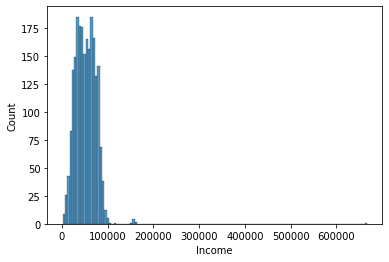

In [10]:
sns.histplot(mrkt_df, x = 'Income')

We see most of the incomes are between 0-10000. We can confirm this with a box plot:

<AxesSubplot:ylabel='Income'>

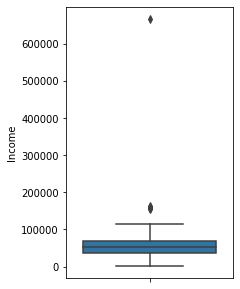

In [11]:
plt.figure(figsize=(3,5))
sns.boxplot(data = mrkt_df, y= 'Income')

Therefore, the best will be to fill the missing values with the median value and not the mean

In [12]:
mrkt_df['Income'] = mrkt_df['Income'].fillna(mrkt_df['Income'].median())

Note: if we want to display the income, it is better to use a log scale. So that the display is centered

<AxesSubplot:xlabel='Income', ylabel='Count'>

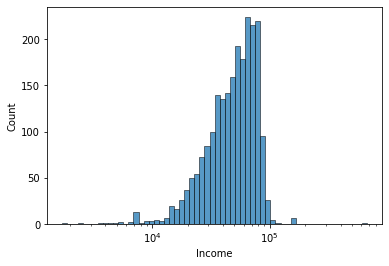

In [13]:
sns.histplot(mrkt_df.Income, log_scale=True)

<a id='section1.3'></a>

#### 1.3 Noisy data - outliers

We want to skim through the data and see if it looks ok. 

So plot boxplots for data that is numeric, except binary data and the ID's

Select only numeric columns:

In [14]:
features = ['ID','Year_Birth', 'Income', 'Kidhome', 'Teenhome','Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases','NumStorePurchases', 'NumWebVisitsMonth' ]

Melt the data into long format, so that we can boxplot all of it at once

In [15]:
melted_mrkt_df = pd.melt(mrkt_df[features], id_vars = 'ID', value_vars = features)
melted_mrkt_df

,ID,variable,value
0,1826,Year_Birth,1970.0
1,1,Year_Birth,1961.0
2,10476,Year_Birth,1958.0
3,1386,Year_Birth,1967.0
4,5371,Year_Birth,1989.0
...,...,...,...
35835,10142,NumWebVisitsMonth,4.0
35836,5263,NumWebVisitsMonth,8.0
35837,22,NumWebVisitsMonth,8.0
35838,528,NumWebVisitsMonth,3.0


We are interested in creating a different boxplot for each `variable`, which is why `col="variable"`

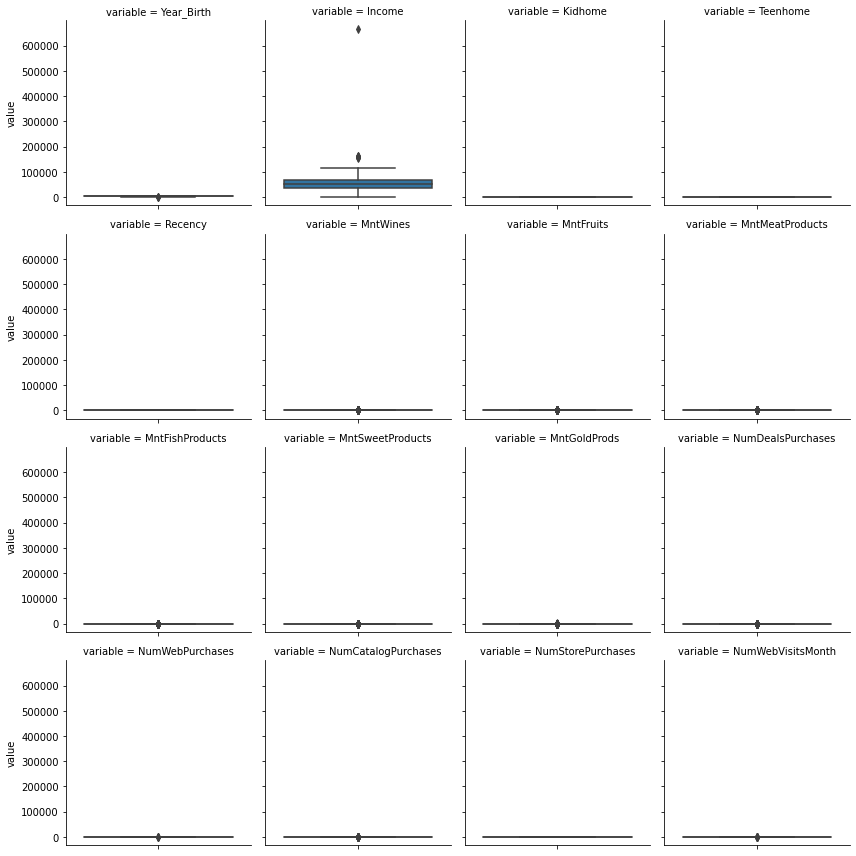

In [16]:
g = sns.FacetGrid(data = melted_mrkt_df, col="variable",  col_wrap=4)
g.map_dataframe(sns.boxplot, y = 'value')
plt.show()

> Your turn
>
> It's hard to read this, because axis y is shared
>
> What can we do??
>
> Hint: google `FacetGrid`

>
> One of the boxplots has some weird outliers. What can we do about them?
>

<AxesSubplot:ylabel='Year_Birth'>

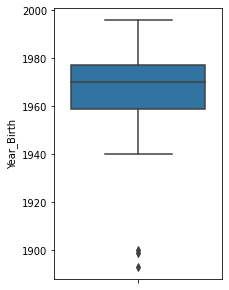

In [17]:
plt.figure(figsize=(3,5))
sns.boxplot( y = 'Year_Birth', data = mrkt_df)

In [18]:
mrkt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2240 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

#### 1.4 Transformations

Change the date column to a date type

In [19]:
mrkt_df['Dt_Customer'] = pd.to_datetime(mrkt_df['Dt_Customer'])

In [20]:
mrkt_df.dtypes

ID                              int64
Year_Birth                      int64
Education                      object
Marital_Status                 object
Income                        float64
Kidhome                         int64
Teenhome                        int64
Dt_Customer            datetime64[ns]
Recency                         int64
MntWines                        int64
MntFruits                       int64
MntMeatProducts                 int64
MntFishProducts                 int64
MntSweetProducts                int64
MntGoldProds                    int64
NumDealsPurchases               int64
NumWebPurchases                 int64
NumCatalogPurchases             int64
NumStorePurchases               int64
NumWebVisitsMonth               int64
AcceptedCmp3                    int64
AcceptedCmp4                    int64
AcceptedCmp5                    int64
AcceptedCmp1                    int64
AcceptedCmp2                    int64
Response                        int64
Complain    

<a id='section2'></a>

### 2. Understand the data

The total number of dependents in the home ('Dependents') can be engineered from the sum of 'Kidhome' and 'Teenhome'

In [21]:
mrkt_df['Dependents'] = mrkt_df['Kidhome'] + mrkt_df['Teenhome']

The year of becoming a customer ('Year_Customer') can be engineered from 'Dt_Customer'

In [22]:
mrkt_df['Year_Customer'] = pd.DatetimeIndex(mrkt_df['Dt_Customer']).year

The total amount spent ('TotalMnt') can be engineered from the sum of all features containing the keyword 'Mnt'

We will use [list comprehension](https://docs.python.org/3.4/tutorial/datastructures.html#list-comprehensions) to do that 

A list comprehension consists of brackets containing an expression followed by a for clause, then zero or more for or if clauses. 

In [23]:
squares = []
for x in range(10):
    squares.append(x**2)
    squares
squares

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [24]:
squares = [x**2 for x in range(10)]
squares

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [25]:
mnt_cols = [col for col in mrkt_df.columns if 'Mnt' in col]
mnt_cols

['MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds']

We have used `.sum()` to sum by columns. Now we want to sum rows. So `axis=1`

In [26]:
mrkt_df['TotalMnt'] = mrkt_df[mnt_cols].sum(axis=1)

The total purchases ('TotalPurchases') can be engineered from the sum of all features containing the keyword 'Purchases'

In [27]:
purchases_cols = [col for col in mrkt_df.columns if 'Purchases' in col]
mrkt_df['TotalPurchases'] = mrkt_df[purchases_cols].sum(axis=1)

The total number of campains accepted ('TotalCampaignsAcc') can be engineered from the sum of all features containing the keywords 'Cmp' and 'Response' (the latest campaign)

In [28]:
campaigns_cols = [col for col in mrkt_df.columns if 'Cmp' in col] + ['Response'] # 'Response' is for the latest campaign
mrkt_df['TotalCampaignsAcc'] = mrkt_df[campaigns_cols].sum(axis=1)

Look at our new columns

In [29]:
mrkt_df[['ID', 'Dependents', 'Year_Customer', 'TotalMnt', 'TotalPurchases', 'TotalCampaignsAcc', 'NumDealsPurchases']].head(10)

,ID,Dependents,Year_Customer,TotalMnt,TotalPurchases,TotalCampaignsAcc,NumDealsPurchases
0,1826,0,2014,1190,15,1,1
1,1,0,2014,577,18,2,1
2,10476,1,2014,251,11,0,1
3,1386,2,2014,11,4,0,1
4,5371,1,2014,91,8,2,2
5,7348,0,2014,1192,17,1,1
6,4073,0,2014,1215,28,2,1
7,1991,1,2014,96,7,0,1
8,4047,1,2014,544,20,0,3
9,9477,1,2014,544,20,0,3


<a id='section3'></a>

The total number of dependents in the home ('Dependents') can be engineered from the sum of 'Kidhome' and 'Teenhome'

In [ ]:
mrkt_df['Dependents'] = mrkt_df['Kidhome'] + mrkt_df['Teenhome']

The year of becoming a customer ('Year_Customer') can be engineered from 'Dt_Customer'

In [31]:
mrkt_df['Year_Customer'] = pd.DatetimeIndex(mrkt_df['Dt_Customer']).year

---
The total amount spent ('TotalMnt') can be engineered from the sum of all features containing the keyword 'Mnt'

We will use [list comprehension](https://docs.python.org/3.4/tutorial/datastructures.html#list-comprehensions) to do that 

A list comprehension consists of brackets containing an expression followed by a for clause, then zero or more for or if clauses. 

In [33]:
squares = []
for x in range(10):
    squares.append(x**2)
    squares
squares

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [34]:
squares = [x**2 for x in range(10)]
squares

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

---

In [36]:
mrkt_df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Complain', 'Country', 'Dependents',
       'Year_Customer', 'TotalMnt', 'TotalPurchases', 'TotalCampaignsAcc'],
      dtype='object')

In [37]:
mnt_cols = [col for col in mrkt_df.columns if 'Mnt' in col]
mnt_cols

['MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'TotalMnt']

We have used `.sum()` to sum by columns. Now we want to sum rows. So `axis=1`

In [40]:
mrkt_df['TotalMnt'] = mrkt_df[mnt_cols].sum(axis=1)

The total purchases ('TotalPurchases') can be engineered from the sum of all features containing the keyword 'Purchases'

In [42]:
purchases_cols = [col for col in mrkt_df.columns if 'Purchases' in col]
mrkt_df['TotalPurchases'] = mrkt_df[purchases_cols].sum(axis=1)

The total number of campains accepted ('TotalCampaignsAcc') can be engineered from the sum of all features containing the keywords 'Cmp' and 'Response' (the latest campaign)

In [44]:
campaigns_cols = [col for col in mrkt_df.columns if 'Cmp' in col] + ['Response'] # 'Response' is for the latest campaign
mrkt_df['TotalCampaignsAcc'] = mrkt_df[campaigns_cols].sum(axis=1)

Look at our new columns

In [33]:
mrkt_df[['ID', 'Dependents', 'Year_Customer', 'TotalMnt', 'TotalPurchases', 'TotalCampaignsAcc', 'NumDealsPurchases']].head(10)

,ID,Dependents,Year_Customer,TotalMnt,TotalPurchases,TotalCampaignsAcc,NumDealsPurchases
0,1826,0,2014,1190,15,1,1
1,1,0,2014,577,18,2,1
2,10476,1,2014,251,11,0,1
3,1386,2,2014,11,4,0,1
4,5371,1,2014,91,8,2,2
5,7348,0,2014,1192,17,1,1
6,4073,0,2014,1215,28,2,1
7,1991,1,2014,96,7,0,1
8,4047,1,2014,544,20,0,3
9,9477,1,2014,544,20,0,3


<a id='section3'></a>

### 3. Correlations - patterns in the data

To find patterns in the data, we need to find correlations in the data

To understand what type of correlation, plot the histograms

In [45]:
features = ['ID','Income', 'Dependents','TotalMnt','TotalPurchases', 'TotalCampaignsAcc', 'NumWebVisitsMonth', 'NumWebPurchases', 'NumDealsPurchases']

In [46]:
melted_mrkt_df = pd.melt(mrkt_df[features], id_vars = 'ID', value_vars = features)

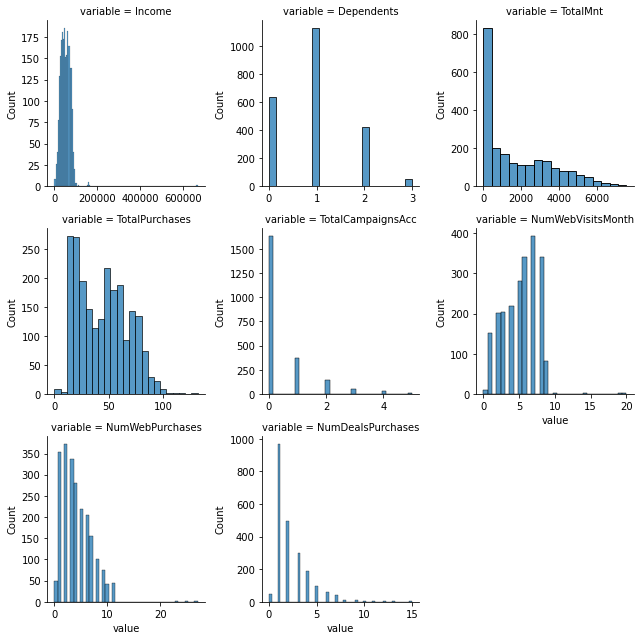

In [47]:
g = sns.FacetGrid(data = melted_mrkt_df, col="variable", col_wrap=3, sharex=False, sharey=False)
g.map_dataframe(sns.histplot, x = "value")
plt.show()

This is not even close to a normal distribution, so use kendall-tau

Use all numeric columns except the 'ID' column

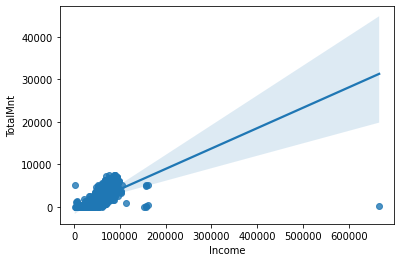

In [51]:
sns.regplot(x='Income', y='TotalMnt', data=mrkt_df);

Try again, less features:

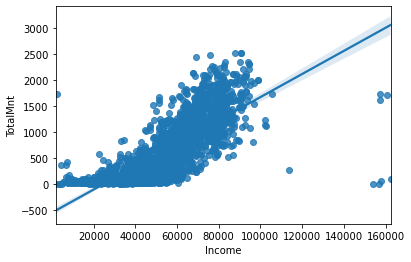

In [39]:
sns.regplot(x='Income', y='TotalMnt', data=mrkt_df[mrkt_df['Income'] < 200000]);

We found some correlations :-)

Let's begin with income and spendings

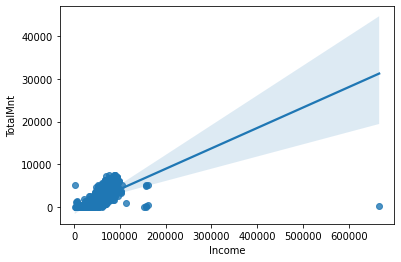

In [50]:
sns.regplot(x='Income', y='TotalMnt', data=mrkt_df);

the same, but remove the outliers:

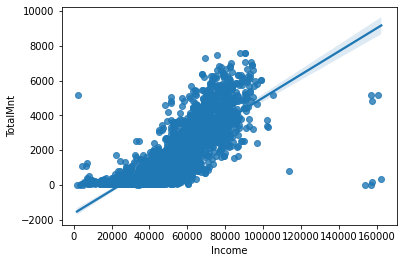

In [51]:
sns.regplot(x='Income', y='TotalMnt', data=mrkt_df[mrkt_df['Income'] < 200000]);

---

>##### Observation 1:
>
>The higher the income is, the more you spend
>
> (a bit trivial)
---

A plot illustrating negative effect of having dependents (kids & teens) on spending:
    


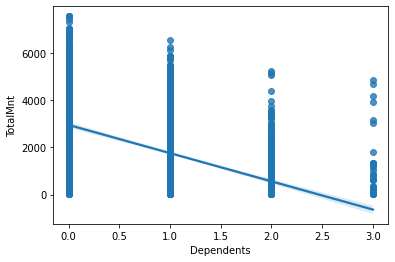

In [52]:
sns.regplot(x='Dependents', y='TotalMnt', data=mrkt_df);

A linear plot doesn't look good here since data is discrete (same for ordinal data - e.g. - none, few, many)

Let's try a boxplot instead

<AxesSubplot:xlabel='Dependents', ylabel='TotalMnt'>

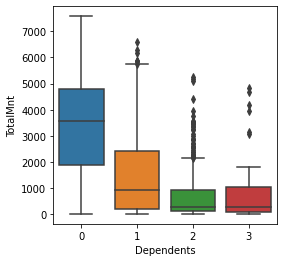

In [53]:
plt.figure(figsize=(4,4))
sns.boxplot(x='Dependents', y='TotalMnt', data=mrkt_df)

A plot illustrating positive effect of having dependents (kids & teens) on number of deals purchased:

<AxesSubplot:xlabel='Dependents', ylabel='NumDealsPurchases'>

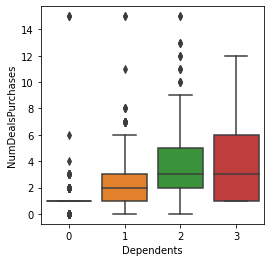

In [54]:
plt.figure(figsize=(4,4))
sns.boxplot(x='Dependents', y='NumDealsPurchases', data=mrkt_df)

put these two plots together for our observation:

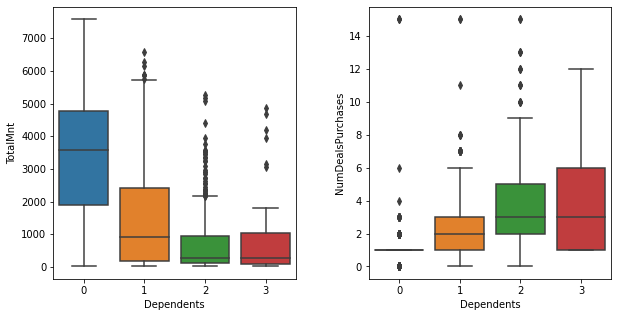

In [55]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
plt.subplots_adjust(wspace = 0.3)
sns.boxplot(x='Dependents', y='TotalMnt', data=mrkt_df, ax = ax[0])
sns.boxplot(x='Dependents', y='NumDealsPurchases', data=mrkt_df, ax = ax[1])
plt.show()

---

>##### Observation 2:
>
>People with more kids spend less
>
>People with more kids buy more deals


---

Plots illustrating the positive effect of campaigns

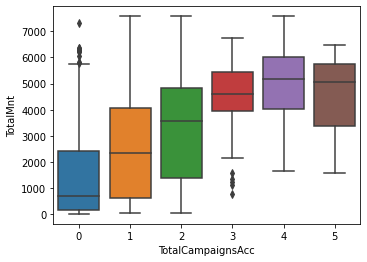

In [56]:
plt.figure(figsize=(5.5,4))
sns.boxplot(x='TotalCampaignsAcc', y='TotalMnt', data=mrkt_df);

---

>##### Observation 3:
>
>Campaigns seem to be working

---

Do people who access campaigns also buy more deals?

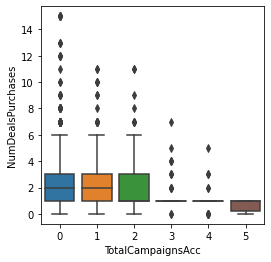

In [57]:
plt.figure(figsize=(4,4))
sns.boxplot(x='TotalCampaignsAcc', y='NumDealsPurchases', data=mrkt_df);

Doesn't seem so. But maybe we need to look at different countries? 


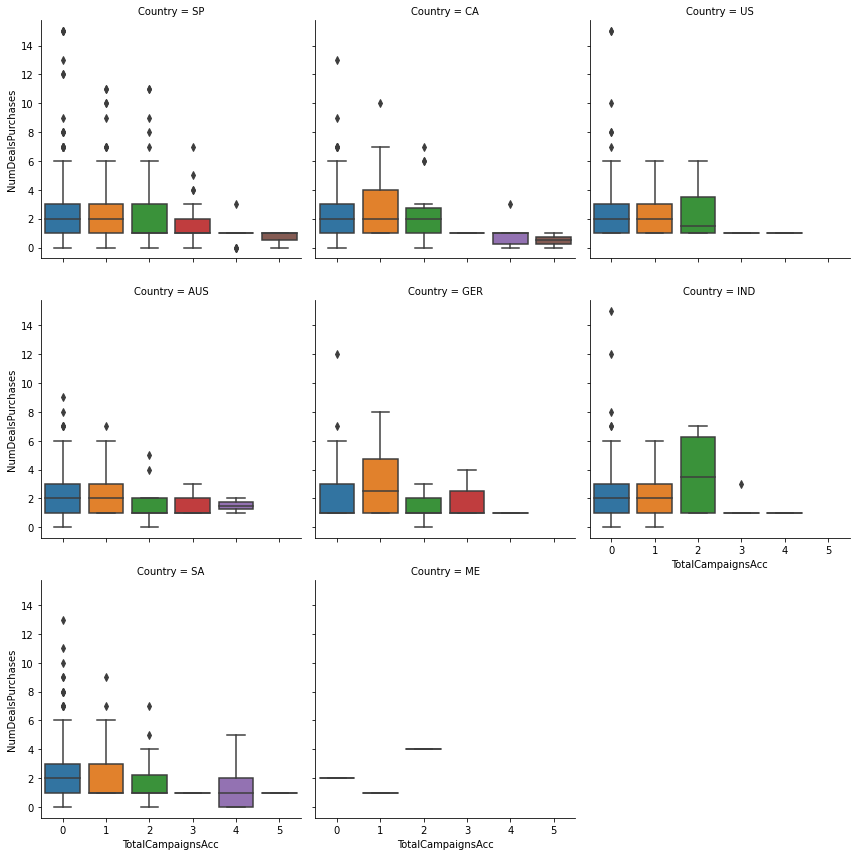

In [58]:
sns.catplot(
    data=mrkt_df, x='TotalCampaignsAcc', y='NumDealsPurchases',
    col='Country', kind='box', col_wrap=3, height=4
)


Note: maybe we need to try: different years? number of dependants? maratial status?

---

>##### Observation??
>
> Campigns don't seem to corrolate with deals, even for different countries (this may be a good thing)
>
> This is not really an observation, since it doesn't focus on finding a new connection. It is only an observation if the company currently believes that there is a connection and you're proving them wrong.
---

What about web visits and web purchases?

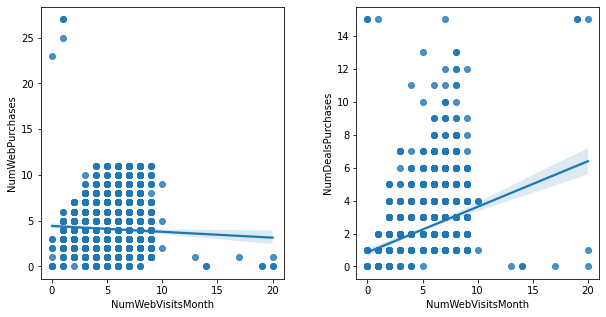

In [59]:
fig, ax = plt.subplots(1,2,figsize=(10, 5))
sns.regplot(x='NumWebVisitsMonth', y='NumWebPurchases', data=mrkt_df, ax=ax[0])
sns.regplot(x='NumWebVisitsMonth', y='NumDealsPurchases', data=mrkt_df, ax = ax[1])
plt.subplots_adjust(wspace = 0.3)

---

>##### Observation 4:
>
> Number of web visits in the last month is not positively correlated with number of web purchases
>
> Instead, it is positively correlated with the number of deals purchased, suggesting that deals are an effective way of stimulating purchases on the website

---

<a id='section4'></a>

### 4. Categorical data

<div>
<img src="images/categories.jpeg" width="400"/>
</div>


We have some categorical data.

Plot it in one row, or on seperate rows. Here's one row:

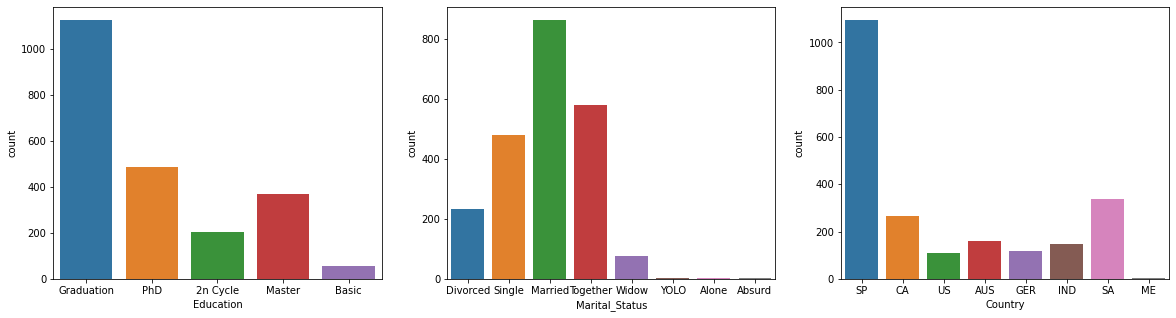

In [60]:
fig, axes = plt.subplots(figsize=(20, 5), ncols=3)
sns.countplot(ax=axes[0], x="Education", data=mrkt_df)
sns.countplot(ax=axes[1], x="Marital_Status", data=mrkt_df)
sns.countplot(ax=axes[2], x="Country", data=mrkt_df)
plt.show()


Let's look at the marital status:

In [61]:
mrkt_df.groupby('Marital_Status')[['ID']].count()

,ID
Marital_Status,
Absurd,2
Alone,3
Divorced,232
Married,864
Single,480
Together,580
Widow,77
YOLO,2


##### Is there a correlation between marital status and spendings?

Create a df that holds only the status's we're interested in - the four biggest categories

In [62]:
status_mrkt = mrkt_df.loc[(mrkt_df.Marital_Status  == 'Single')|(mrkt_df.Marital_Status == 'Married')|(mrkt_df.Marital_Status == 'Together')|(mrkt_df.Marital_Status == 'Divorced')].copy()

Create one-hot encodings for the categorical variables:

In [63]:
features2 = ['Income', 'Dependents','TotalMnt','TotalPurchases', 'TotalCampaignsAcc', 'NumDealsPurchases', 'NumWebVisitsMonth', 'NumWebPurchases', 'Marital_Status', 'Response']

status_mrkt = pd.get_dummies(status_mrkt[features2])


One-hot encoding doesn't affect variables that are not categorical

In [64]:
status_mrkt.head()

,Income,Dependents,TotalMnt,TotalPurchases,TotalCampaignsAcc,NumDealsPurchases,NumWebVisitsMonth,NumWebPurchases,Response,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together
0,84835.0,0,3570,45,1,1,1,4,1,1,0,0,0
1,57091.0,0,1731,54,2,1,5,7,1,0,0,1,0
2,67267.0,1,753,33,0,1,2,3,0,0,1,0,0
3,32474.0,2,33,12,0,1,7,1,0,0,0,0,1
4,21474.0,1,273,24,2,2,7,3,1,0,0,1,0


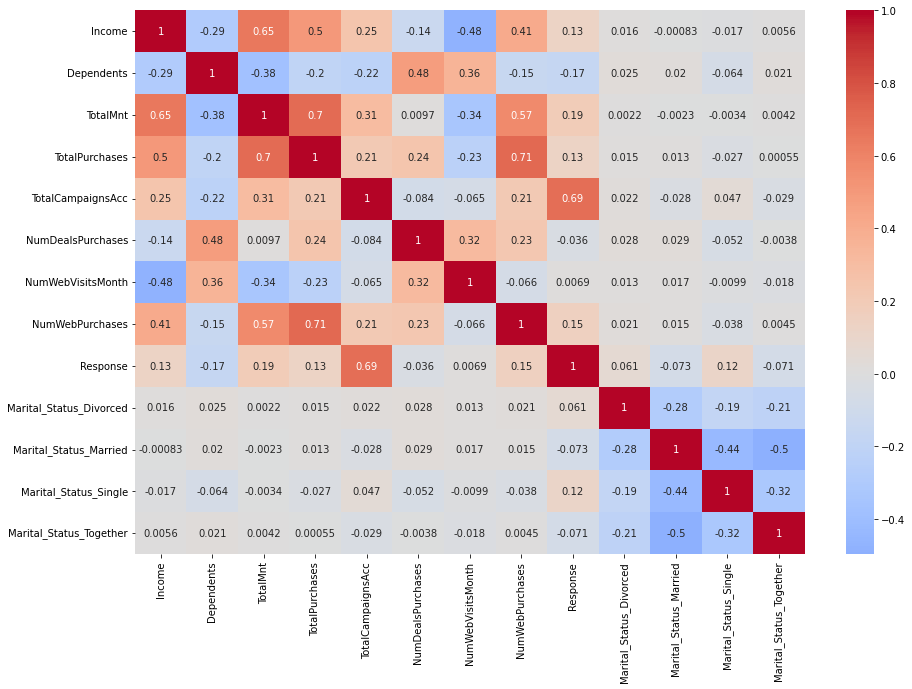

In [65]:
corrs = status_mrkt.corr(method = 'kendall')

plt.figure(figsize=(15,10))  #figure size
sns.heatmap(corrs, cmap='coolwarm', center=0, annot = True);

---

>##### Observation?? 
>
> There isn't any correlation between martial staus and spendings
>
>##### Observations should focus on what there IS, not what there isn't
>
>Let's try to look at the response to campgains

---



Is there a connection between the status, dependents and response?

In [66]:
grouped_mrkt = mrkt_df.groupby(['Marital_Status', 'Dependents'])['Response' ].aggregate('mean').reset_index()
grouped_mrkt

,Marital_Status,Dependents,Response
0,Absurd,0,0.500000
1,Alone,1,0.000000
2,Alone,2,0.500000
3,Divorced,0,0.448276
4,Divorced,1,0.108333
5,Divorced,2,0.183673
6,Divorced,3,0.000000
7,Married,0,0.182609
8,Married,1,0.091314
9,Married,2,0.089286


If we want a table, we can groupby, and then unstack:

In [67]:
table_mrkt = mrkt_df.groupby(['Marital_Status', 'Dependents'])['Response' ].aggregate('mean').unstack()
table_mrkt

Dependents,0,1,2,3
Marital_Status,,,,
Absurd,0.500000,NaN,NaN,NaN
Alone,NaN,0.000000,0.500000,NaN
Divorced,0.448276,0.108333,0.183673,0.000000
Married,0.182609,0.091314,0.089286,0.000000
Single,0.389222,0.129464,0.150685,0.062500
Together,0.162338,0.086957,0.071429,0.066667
Widow,0.370370,0.181818,0.176471,NaN
YOLO,NaN,0.500000,NaN,NaN


Or we can use a pivot table to obtain the same results:

In [68]:
mrkt_df.pivot_table('Response', index='Marital_Status', columns='Dependents', aggfunc='mean')  #aggfunc = 'mean' is the default

Dependents,0,1,2,3
Marital_Status,,,,
Absurd,0.500000,NaN,NaN,NaN
Alone,NaN,0.000000,0.500000,NaN
Divorced,0.448276,0.108333,0.183673,0.000000
Married,0.182609,0.091314,0.089286,0.000000
Single,0.389222,0.129464,0.150685,0.062500
Together,0.162338,0.086957,0.071429,0.066667
Widow,0.370370,0.181818,0.176471,NaN
YOLO,NaN,0.500000,NaN,NaN


Why would we want a table? Because with a table it's easier to figure out what's going on and what we should plot

Single & Divorced with no kids are more likly to respond to a campaign

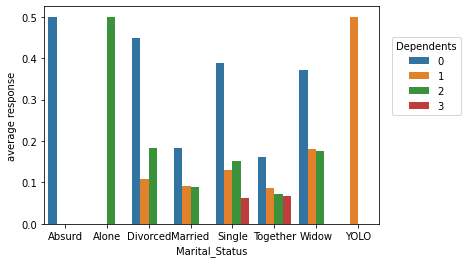

In [69]:
ax = sns.barplot(data = grouped_mrkt, x='Marital_Status', y='Response', hue = 'Dependents')
ax.set(ylabel='average response')
plt.legend(title='Dependents', loc=(1.04,0.5)) #the legend is outside since it didn't fit inside
plt.show()

remeber we plotted categorical variables?

<AxesSubplot:xlabel='Marital_Status', ylabel='count'>

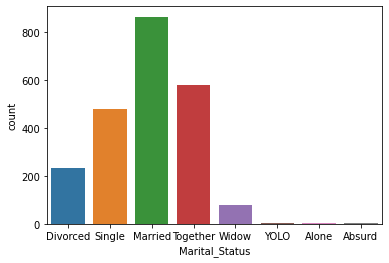

In [70]:
sns.countplot(x="Marital_Status", data=mrkt_df)

since there are almost no widows, 'YOLO's, alones and 'Absurd's, lests ignore them

##### Note: this doesn't just make the figure look prettier. It's important to ignore them. We don't want to reach a conclusion if based on 2-3 YOLO's..

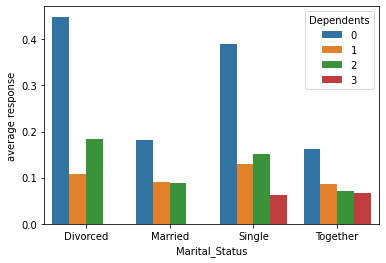

In [71]:
group_slice = grouped_mrkt[(grouped_mrkt.Marital_Status == 'Divorced') | (grouped_mrkt.Marital_Status == 'Single')  | (grouped_mrkt.Marital_Status == 'Married') | (grouped_mrkt.Marital_Status == 'Together')]
ax = sns.barplot(data = group_slice, x='Marital_Status', y='Response', hue = 'Dependents')
ax.set(ylabel='average response')
plt.legend(title='Dependents', loc=('upper right')) #the legend fits inside now
plt.show()

---

>##### Observation 5 
>
> Single & Divorced with no kids are more likly to respond to a campaign - average response is higher than 30%
>
> Married & Together with no kids respond at around 20%
>

 

---

Is this it? No!! There is always more to do. We haven't touched country, education, or campaign responses and much more. 


---
> A summary of new functions:
>
>* `drop()` - remove labels or columns [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html?highlight=drop#pandas.DataFrame.drop)
>
>* `str.replace('x','y')` - replace string x with string y
>
>* `reset_index(drop=true)` - resets the index. As defult, the old index is added as a column. Use drop=True to avoid this. [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html)
>
>* `plt.subplots_adjust` - a matplotlib function. adjusts space between the plots. [documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots_adjust.html)
>
>* `sum(axis=1)` - sums the values according to the rows, instead of the default sum by columns
>
>* create a list using [list comprehension](https://docs.python.org/3.4/tutorial/datastructures.html#list-comprehensions) - "do something for data in dataframe if condition holds"
>
>* `catplot()` - plot categorical variables onto a grid. [documentation](https://seaborn.pydata.org/generated/seaborn.catplot.html)
>
>* `countplot()` - counts observations for each category (this is like a histogram, but for categorical data)
>
>* `pd.get_dummies()` - creates one-hot encodings for categorical variables. [documentation](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)
>
>* `unstack()` - change the hiearachy of data. [documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.unstack.html)
>
>* `pivot()` - create a pivot table to group and summarize data. [documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html)
---